In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io
import numpy as np
from genaibook.core import show_images

# Custom Dataset class
class FreyFaceDataset(Dataset):
    def __init__(self, path="frey_rawface.mat"):
        data = scipy.io.loadmat(path)["ff"].T
        self.images = data.reshape(-1, 28, 20).astype(np.float32) / 255.0  # normalize

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)  # shape: [1, 28, 20]
        return img


In [18]:

bs = 64  # batch size
train_dataset = FreyFaceDataset()
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
train_dataset


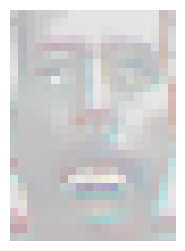

In [17]:
show_images(train_dataset[:4])

In [7]:
import matplotlib as mpl

In [8]:
mpl.rcParams["image.cmap"] = "gray_r"

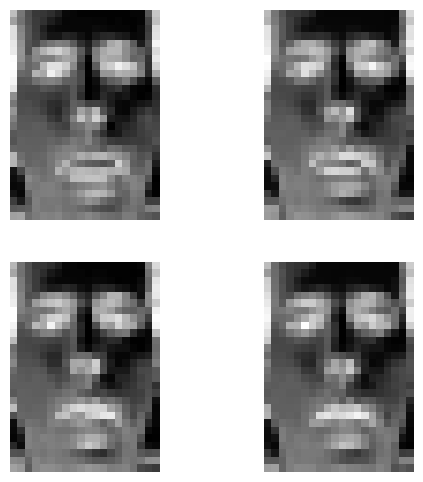

In [9]:
show_images(images[:4])

In [10]:
from torchvision import transforms

# Encoder

In [ ]:
def face_to_tensor(samples):
    t = transforms.ToTensor()
    samples['image'] = [t(image) for image in samples["image"]]
    return samples

In [10]:
mnist = mnist.with_transform(mnist_to_tensor)

In [11]:
mnist['train'] = mnist['train'].shuffle(seed=1337)

In [12]:
x = mnist['train']['image'][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

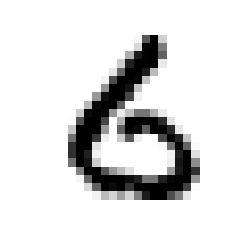

In [13]:
show_images(mnist['train']['image'][0])

In [14]:
from torch.utils.data import DataLoader
from torch import nn

In [15]:
bs = 64
train_dataloader = DataLoader(mnist['train']['image'], batch_size=bs, shuffle=True)

In [16]:
# Makes a 2D convolutional layer, then appends a normalization layer and nonlinearity (ReLU)
# NOTE: normalization is based on mean and standard deviation to make sure input stays in a predictable range
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,   
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [17]:
# converts 28 x 28 images into vectors of 16 numbers
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x) # batch size, 128, 14, 14
        x = self.conv2(x) # bs, 256, 7, 7
        x = self.conv3(x) # bs 512, 3, 3
        x = self.conv4(x) # bs 1024, 1, 1
        # Keep batch dimension when flattening
        x = self.linear(x.flatten(start_dim=1)) # bs 16
        return x

In [18]:
mnist['train']['image'][0].shape

torch.Size([1, 28, 28])

In [19]:
in_channels = 1
x = mnist['train']['image'][0][None, :]
encoder = Encoder(in_channels).eval()

In [20]:
encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [21]:
encoded

tensor([[-0.0137, -0.0121,  0.0303, -0.0321,  0.0176, -0.0208,  0.0283,  0.0279,
          0.0191, -0.0112,  0.0148, -0.0077, -0.0186, -0.0068,  0.0223,  0.0062]],
       grad_fn=<AddmmBackward0>)

In [22]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

# Decoder

In [23]:
def conv_transpose_block(
        in_channels, 
        out_channels, 
        kernel_size=3, 
        stride=2, 
        padding=1, 
        output_padding=0, 
        with_act=True
    ):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding
        )
    ]
    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [24]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.linear = nn.Linear(16, 1024 * 4 * 4)
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)


    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x) # bs, 1024*4*4
        x = x.reshape((bs, 1024, 4, 4)) # bs, 1024, 4, 4
        x = self.t_conv1(x) # bs, 512, 7, 7
        x = self.t_conv2(x) # bs, 256, 14, 14
        x = self.t_conv3(x) # bs, 1, 28, 28
        return x

In [25]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

# AutoEncoder

In [26]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [27]:
model = AutoEncoder(1)

# Summary of AutoEncoder Model

In [28]:
import torchsummary

In [29]:
torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [30]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from genaibook.core import get_device

In [32]:
num_epochs = 10
lr = 1e-4
device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

In [33]:
losses = [] # List to store the loss values for plotting

In [34]:
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
        batch = batch.to(device)
        preds = model(batch)
        loss = F.mse_loss(preds, batch)
        inner.set_postfix(loss=f'{loss.cpu().item():.3f}')
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f'{loss.cpu().item():.3f}', lr=f'{lr:.0e}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

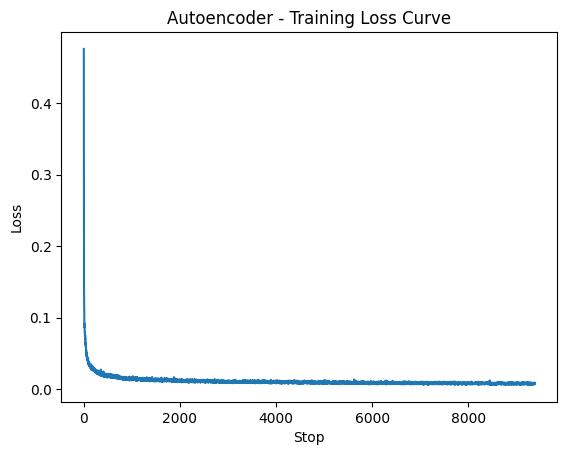

In [35]:
plt.plot(losses)
plt.xlabel("Stop")
plt.ylabel("Loss")
plt.title("Autoencoder - Training Loss Curve")
plt.show()

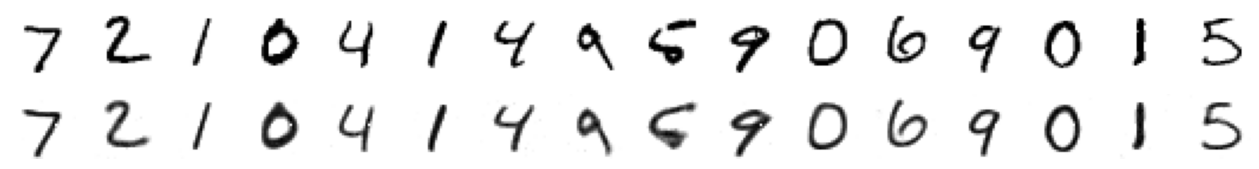

In [36]:
# Reconstruct images using our model
eval_bs = 16
eval_dataloader = DataLoader(mnist['test']['image'], batch_size=eval_bs)
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## In the above image, the first row is actual images from mnist, the second row is reconstructed with our model

### great success 🤝

# Latent Space Exploration

## Compress vector representations to 2 floats instead - how will this affect the model's ability to encode/decode?

In [37]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024)
        )
        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [38]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
        self.t_conv_layers = nn.Sequential(
            conv_transpose_block(1024, 512),
            conv_transpose_block(512, 256, output_padding=1),
            conv_transpose_block(256, out_channels, output_padding=1, with_act=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [39]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [40]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    model.train()
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
            batch = batch.to(device)
            preds = model(batch)
            loss = F.mse_loss(preds, batch)
            inner.set_postfix(loss=f'{loss.cpu().item():.3f}')
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f'{loss.cpu().item():.3f}', lr=f'{lr:.0e}')
    return losses

In [41]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

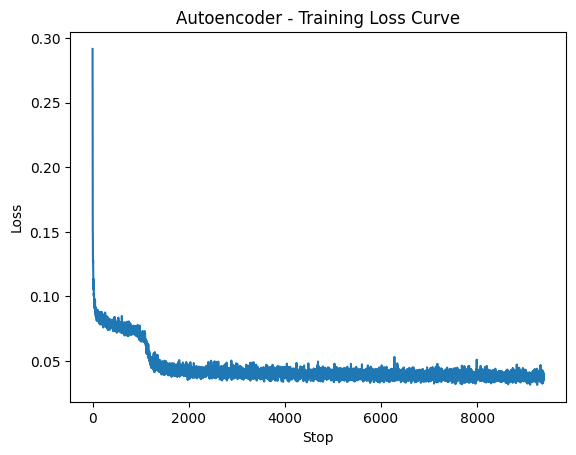

In [42]:
plt.plot(losses)
plt.xlabel("Stop")
plt.ylabel("Loss")
plt.title("Autoencoder - Training Loss Curve")
plt.show()

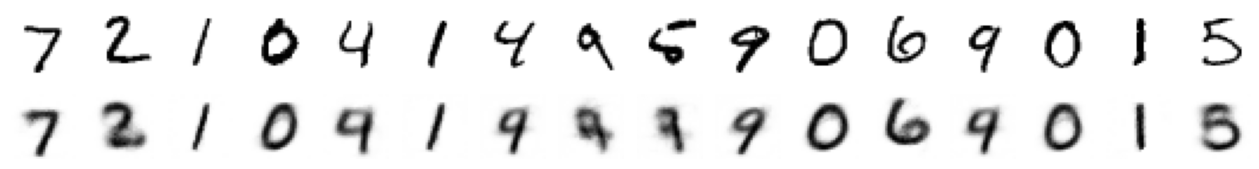

In [43]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

# Visualise Latent Space

### Train model with Latency = 2 so we can plot the latency spread

In [44]:
images_labels_dataloader = DataLoader(mnist['test'], batch_size=512)

In [45]:
import pandas as pd

In [46]:
df = pd.DataFrame({
    'x': [],
    'y': [],
    'label': [],
})

In [47]:
for batch in tqdm(iter(images_labels_dataloader), total=len(images_labels_dataloader)):
    encoded = ae_model.encode(batch['image'].to(device)).cpu()
    new_items = {
        'x': [t.item() for t in encoded[:, 0]],
        'y': [t.item() for t in encoded[:, 1]],
        'label': batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

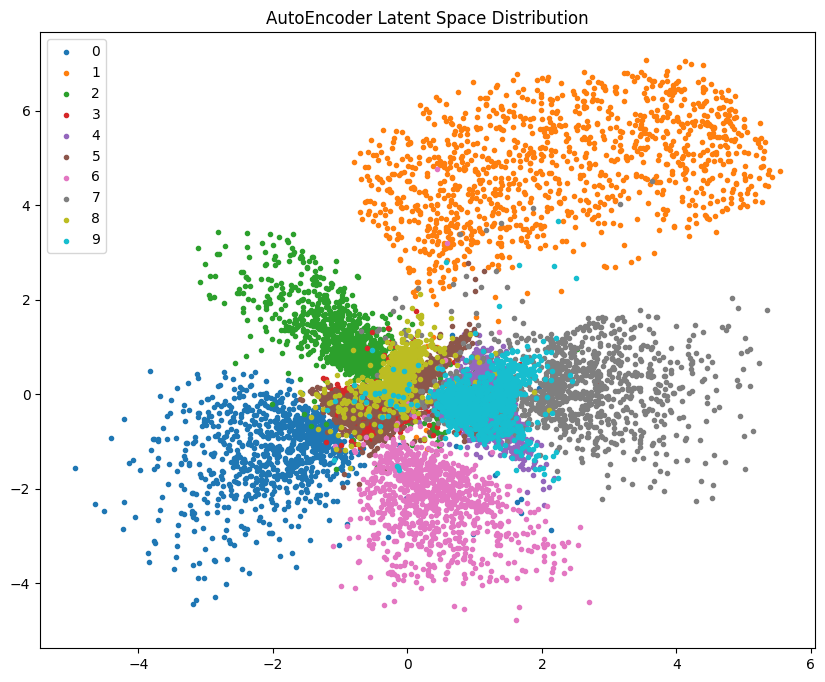

In [48]:
plt.figure(figsize=(10, 8))
for label in range(10):
    points = df[df['label'] == label]
    plt.scatter(points['x'], points['y'], label=label, marker=".")
plt.title('AutoEncoder Latent Space Distribution')
plt.legend()
plt.show()

In [ ]:
# Some random latent samples - see how well decoder works!
N = 16
z = torch.rand((N, 2)) * 8 - 4

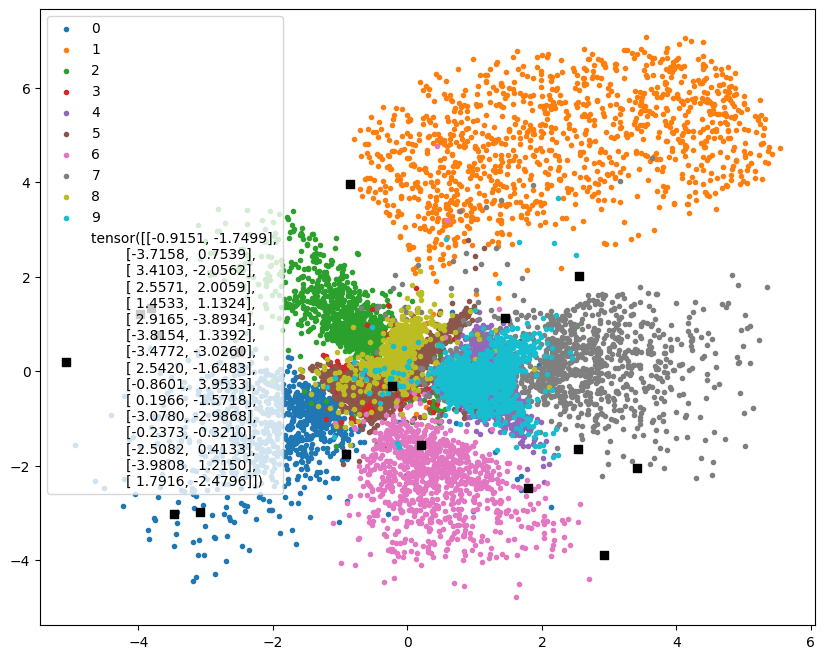

In [52]:
plt.figure(figsize=(10, 8))
for label in range(10):
    points = df[df['label'] == label]
    plt.scatter(points['x'], points['y'], label=label, marker='.')
plt.scatter(z[:, 0], z[:, 1], label=z, marker='s', color="black")
plt.legend()
plt.show()

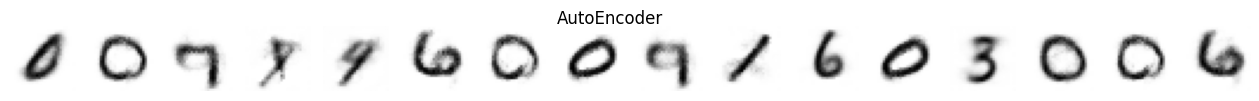

In [53]:
# Generate images from fake latent samples:
ae_decoded = ae_model.decode(z.to(device))
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")

## Let's try upping the latency from 2 to 16!

In [54]:
ae_model_16 = AutoEncoder(in_channels=1, latent_dims=16)
ae_model_16.to(device)
losses = train(ae_model_16)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

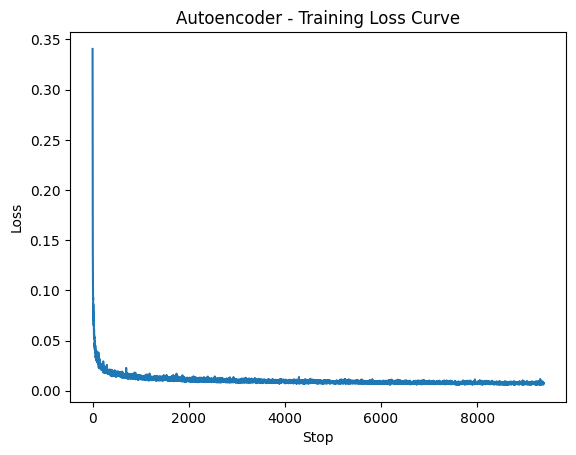

In [55]:
plt.plot(losses)
plt.xlabel("Stop")
plt.ylabel("Loss")
plt.title("Autoencoder - Training Loss Curve")
plt.show()

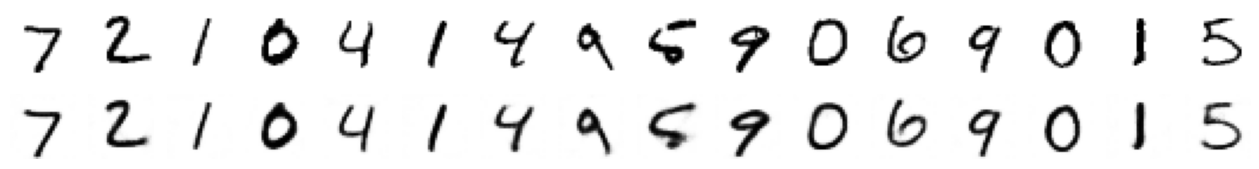

In [56]:
ae_model_16.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model_16(eval_batch.to(device)).cpu()

batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)


# VAEs: Representations with Gaussian Spread (instead of points)

In [58]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024)
        )

        ## THIS IS THE MAGIC - define fully connected layers for mean and log variance
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [61]:
# Use same encoder, so here is the full VAE:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self,x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)

        # Sample from distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        return reconstructed, mu, logvar
    
    def sample(self, mu, std):
        # Sample from N(0, I), translate and scale
        # Reparameterization
        eps = torch.randn_like(std)
        return mu + eps * std

In [65]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none"
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [66]:
# Train model
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        'loss': [],
        'reconstruction_loss': [],
        'kl_loss': [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through model
            reconstructed, mu, logvar = model(batch)

            # Compute losses
            loss, reconstruction_loss, kl_loss = vae_loss(batch, reconstructed, mu, logvar)

            # Display loss and store for plotting
            inner.set_postfix(loss=f'{loss.cpu().item():.3f}')
            losses['loss'].append(loss.item())
            losses['reconstruction_loss'].append(reconstruction_loss.mean().item())
            losses['kl_loss'].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f'{loss.cpu().item():.3f}', lf=f'{lr:.0e}')
    return losses

In [67]:
vae_model = VAE(in_channels=1, latent_dims=2) # Back down to 2 so we can visualize it 👀
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

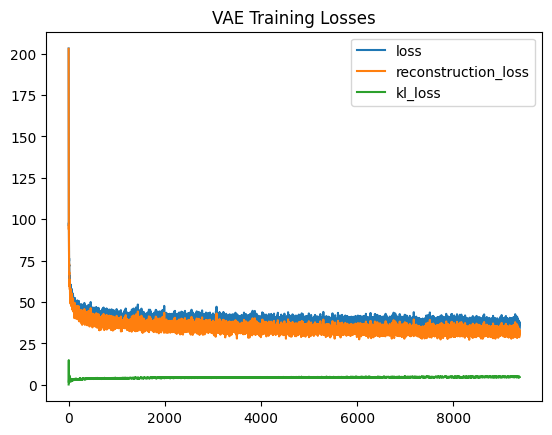

In [68]:
for k,v in losses.items():
    plt.plot(v, label=k)
plt.title("VAE Training Losses")
plt.legend()

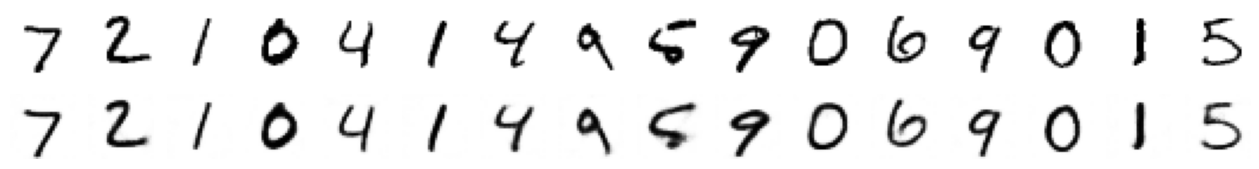

In [69]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))
    batch_vs_pres = torch.cat((eval_batch, predicted))
    show_images(batch_vs_preds, imsize=1, nrows=2)

In [70]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": []
    }
)

In [72]:
for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    mu, _ = vae_model.encode(batch['image'].to(device))
    mu = mu.to("cpu")
    new_items = {
        'x': [t.item() for t in mu[:, 0]],
        'y': [t.item() for t in mu[:, 1]],
        'label': batch['label'],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

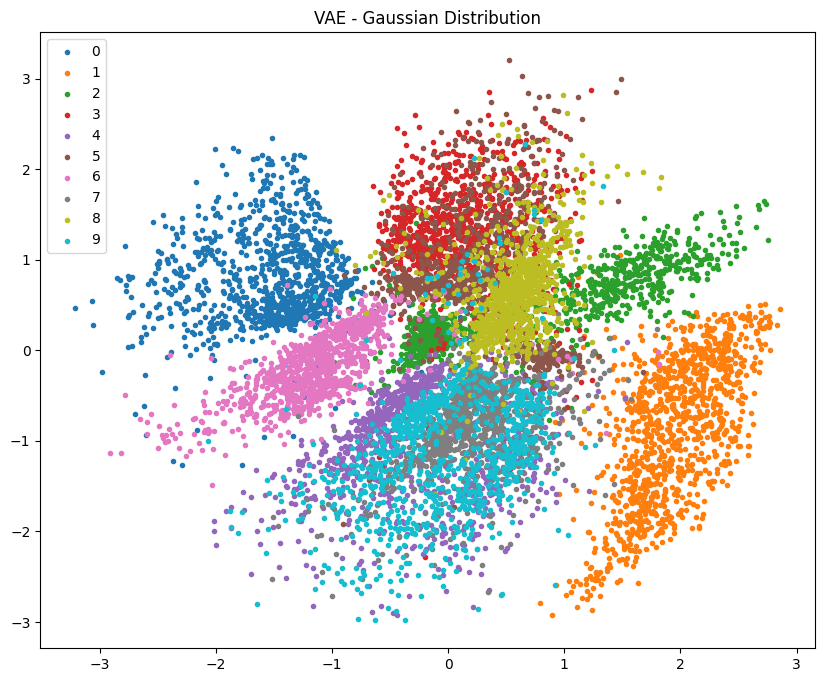

In [74]:
plt.figure(figsize=(10, 8))
for label in range(10):
    points = df[df['label'] == label]
    plt.scatter(points['x'], points['y'], label=label, marker='.')
plt.legend()
plt.title('VAE - Gaussian Distribution')
plt.show()

# Compare AutoEncoder to VAE

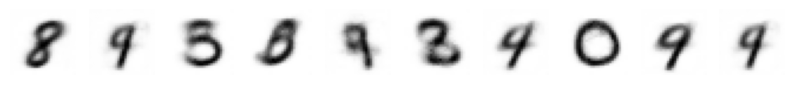

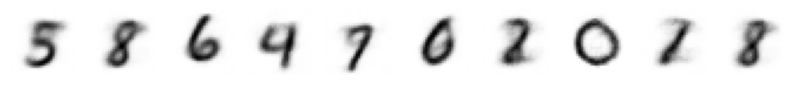

In [77]:
z = torch.normal(0, 1, size=(10,2))
ae_decoded = ae_model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

show_images(ae_decoded.cpu(), imsize=1, nrows=1)
show_images(vae_decoded.cpu(), imsize=1, nrows=1)

### VAE is more number-like because is encouraged not to veer away from normal distribution

## VAE for samples where x = 0.8 and y = 2 or y = -2

Let's see the transitions!

In [78]:
import numpy as np

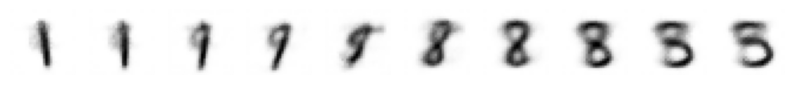

In [79]:
with torch.inference_mode():
    inputs = []
    for y in np.linspace(-2, 2, 10):
        inputs.append([0.8, y])
    z = torch.tensor(inputs, dtype=torch.float32).to(device)
    decoded = vae_model.decode(z)
show_images(decoded.cpu(), imsize=1, nrows=1)

# Visualize Gaussian Distribution to see transitions in latent space

In [82]:
inputs = []
for x in np.linspace(-2, 2, 20):
    for y in np.linspace(-2, 2, 20):
        inputs.append([x, y])
z = torch.tensor(inputs, dtype=torch.float32).to(device)
decoded = vae_model.to(device).decode(z)

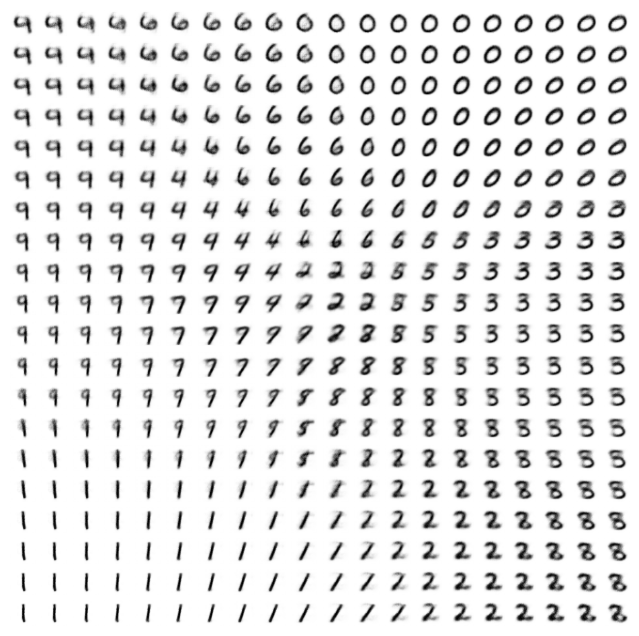

In [83]:
show_images(decoded.cpu(), imsize=0.4, nrows=20)

# VAE upped to 16 dimensions!

In [ ]:
vae_model = VAE(in_channels=1, latent_dims=2) # Back down to 2 so we can visualize it 👀
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
for k,v in losses.items():
    plt.plot(v, label=k)
plt.title("VAE Training Losses")
plt.legend()

In [ ]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))
    batch_vs_pres = torch.cat((eval_batch, predicted))
    show_images(batch_vs_preds, imsize=1, nrows=2)

In [ ]:
z = torch.normal(0, 1, size=(10,2))
ae_decoded = ae_model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

show_images(ae_decoded.cpu(), imsize=1, nrows=1)
show_images(vae_decoded.cpu(), imsize=1, nrows=1)